In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats

import statsmodels.api as sm

import quandl
from itertools import combinations

# Question 1

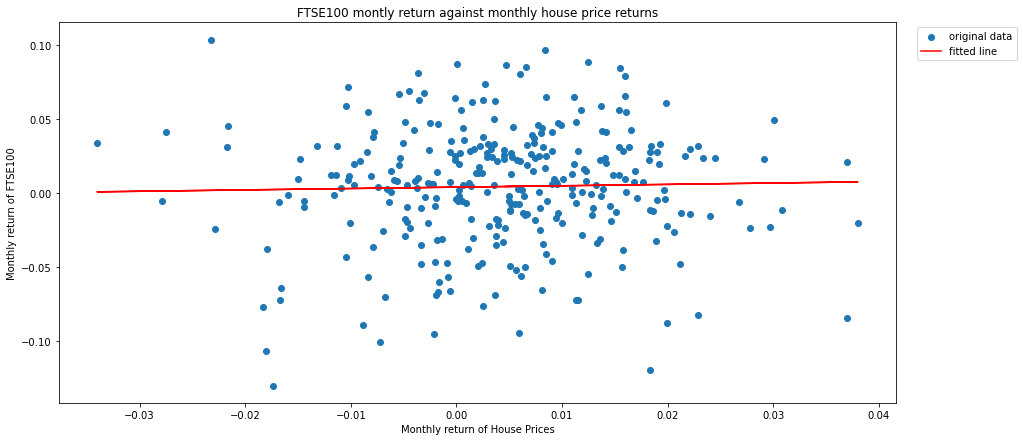

LinregressResult(slope=0.09324142754349966, intercept=0.004047837686662456, rvalue=0.026551295701909915, pvalue=0.6409049000031651, stderr=0.1997058644355541, intercept_stderr=0.002437025309251721)
correlation coefficient is: 0.026551295701909918

H0: slope = 0 (null hypothesis)
H1: slope != 0 (alternative hypothesis)
We us a two-tailed test because the alternative hypothesis is that the slope is not equal to zero
the p-value is: 0.6409049000031651
Since the p-value is greater than or equal to 0.05, we accept the null hypothesis. With 95% confidence level, we can say that the slope is zero. This means that there is no significant relationship between the monthly return of houses and stocks


In [2]:
# Question 1

# read excel file and load it into a dataframe
dfMHP = pd.read_excel('Monthly.xls')
# rename the Unnamed column as date
dfMHP.rename(columns = {'Unnamed: 0':'Date'}, inplace = True)

# read the FTSE csv file
dfFTSE = pd.read_csv('FTSE100.csv')
# converted the date column to a date type
dfFTSE['Date'] = pd.to_datetime(dfFTSE['Date'])

# used only rows where the date is between 1991 and 2016
dfMHP = dfMHP.loc[dfMHP['Date'].between('1991-01-01', '2016-12-31')]
dfFTSE = dfFTSE.loc[dfFTSE['Date'].between('1991-01-01', '2016-12-31')]
dfFTSE = dfFTSE.sort_values(by="Date")

# calculate the montly return
dfMHP = dfMHP['Average House Price'].pct_change()
dfMHP = dfMHP.dropna()
dfFTSE = dfFTSE['Adj Close'].pct_change()
dfFTSE = dfFTSE.dropna()


# calculate the linear regression function
result = stats.linregress(dfMHP, dfFTSE)

# get slope
slope = result.slope
# get the intercept
intercept = result.intercept
# the prediction function
y_hat = slope*dfMHP + intercept

# # making the graph bigger for better visibility
plt.figure(figsize=(15, 7))

# # plot original data
plt.scatter(dfMHP, dfFTSE, label="original data")
# # plot regression line
plt.plot(dfMHP,y_hat,color="red", label="fitted line")

# # naming the x axis
plt.xlabel('Monthly return of House Prices')
# # naming the y axis
plt.ylabel('Monthly return of FTSE100')

# # giving a title to my graph
plt.title('FTSE100 montly return against monthly house price returns')

# # show legend
plt.legend(bbox_to_anchor=(1.15, 1))

plt.show()

print(result)

# print()

# # calculate correlation
# correlation = dfMHP.corr(dfFTSE)
correlation = np.corrcoef(dfMHP, dfFTSE)[0][1]

print('correlation coefficient is: ' + str(correlation))
print()

# hypothesis testing, define null and alternative hypothesis
print('H0: slope = 0 (null hypothesis)')
print('H1: slope != 0 (alternative hypothesis)')
print('We us a two-tailed test because the alternative hypothesis is that the slope is not equal to zero')

# calculate number of sample values
nH = len(dfMHP);
# calculate t statistics for the slope
t = result.slope / result.stderr
# calculate p value
p = stats.t.sf(abs(t), df=nH-2) * 2

# interpret result
print('the p-value is: ' + str(p))
print('Since the p-value is greater than or equal to 0.05, we accept the null hypothesis. With 95% confidence level, we can say that the slope is zero. This means that there is no significant relationship between the monthly return of houses and stocks')



# Question 2

In [3]:

# read the college excel file
dfCollege = pd.read_csv('College.csv')

# a: calculate correlation coefficients
apps = dfCollege['Grad.Rate'].corr(dfCollege['Apps'])
enroll = dfCollege['Grad.Rate'].corr(dfCollege['Enroll'])
outState = dfCollege['Grad.Rate'].corr(dfCollege['Outstate'])
top10 = dfCollege['Grad.Rate'].corr(dfCollege['Top10perc'])
top25 = dfCollege['Grad.Rate'].corr(dfCollege['Top25perc'])

print('apps correlation: ' + str(apps))
print('enroll correlation: ' + str(enroll))
print('outState correlation: ' + str(outState))
print('top10 correlation: ' + str(top10))
print('top25 correlation: ' + str(top25))
print()

# b: building linear regression model using forward regression
# variables to consider
independents = dfCollege[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']]

# a function that use forward regression to select the best model
def forward_regression(X, y,
                       threshold_in,
                       verbose=False):
    initial_list = []
    # tracks included variables     
    included = list(initial_list)
    while True:
        changed=False
        # tracks excluded variables
        excluded = list(set(X.columns)-set(included))
        # a series that stores the p-value of every variable         
        new_pval = pd.Series(index=excluded, dtype='float64')
        # for every column that is not already added        
        for new_column in excluded:
            # build a model adding the variable
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            # add the p-value of the variable to our series           
            new_pval[new_column] = model.pvalues[new_column]
        # get the minimum p-value            
        best_pval = new_pval.min()
        # if p-value is less than the significance level         
        if best_pval < threshold_in:
            # get the index of the minimum p-value, which gives us the column name             
            best_feature = new_pval.idxmin()
            # add this column to included list             
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # if the smallest p-value that we have is greater than the significance level, we have found all the best column so break 
        if not changed:
            break
    # return the list of varibles for the best model 
    return included


# c: the chosen predictor variables
print('the chosen independent variables (forward regression): ' + str(forward_regression(independents, dfCollege['Grad.Rate'],0.05, False)))
print()

# d: using BIC to select the model and comparing the outcomes
# a list containing all possible variables
sample_list = ['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']
# variable to store all the combinations
list_combinations = list()
for n in range(1,len(sample_list) + 1):
    # generate the combinations and add them to the list     
    list_combinations += list(combinations(sample_list, n))
# convert every tuple combination to a list
list_combinations = [list(x) for x in list_combinations]

# a dataframe that contains the columns included in the model and their BIC
bics = pd.DataFrame(columns = ["Cols","BIC"])
# for every combination
for i in range(len(list_combinations)):
    # create a model     
    model = sm.OLS(dfCollege['Grad.Rate'], sm.add_constant(pd.DataFrame(dfCollege[list_combinations[i]]))).fit()
    # store the BIC values     
    bics.loc[i] = [list_combinations[i], model.bic]

# find the model with the least BIC    
print('the model with the least BIC: ' + str(bics.loc[bics['BIC'].idxmin()]['Cols']))
print('its BIC: ' + str(bics.loc[bics['BIC'].idxmin()]['BIC']))
print()


# e: compare accuracy using r-squared 
model_withAll = sm.OLS(dfCollege['Grad.Rate'], sm.add_constant(pd.DataFrame(independents))).fit()
model_chosen = sm.OLS(dfCollege['Grad.Rate'], sm.add_constant(pd.DataFrame(dfCollege[['Outstate', 'Top25perc']]))).fit()
# their r-squared values
print("R-squared with all variables: " + str(model_withAll.rsquared))
print("R-squared with 2 variables: " + str(model_chosen.rsquared))
print()

# f: predicting for CMU
# get the row for CMU
cmu_row = dfCollege.loc[dfCollege['Unnamed: 0'] == "Carnegie Mellon University"]
# get only the wanted columns
cmu_sliced = cmu_row[['Apps', 'Enroll', 'Outstate', 'Top10perc', 'Top25perc']]
# because predict expects [1, independent values]
print('prediction by model with all variables: ' + str (model_withAll.predict([1] + cmu_sliced.iloc[0].tolist())))
print('prediction by model with 2 variables: ' + str(model_chosen.predict([1] + cmu_sliced[['Outstate', 'Top25perc']].iloc[0].tolist())))
print('actual garduation rate: ' + str(cmu_row['Grad.Rate'].iloc[0]))


apps correlation: 0.14675459955109238
enroll correlation: -0.022341038639948456
outState correlation: 0.571289928248201
top10 correlation: 0.4949892348013402
top25 correlation: 0.47728116437578355

the chosen independent variables (forward regression): ['Outstate', 'Top25perc']

the model with the least BIC: ['Outstate', 'Top25perc']
its BIC: 6274.3329824422635

R-squared with all variables: 0.3861582005130556
R-squared with 2 variables: 0.37776441749868717

prediction by model with all variables: [89.20112305]
prediction by model with 2 variables: [87.09352366]
actual garduation rate: 74


# Question 3

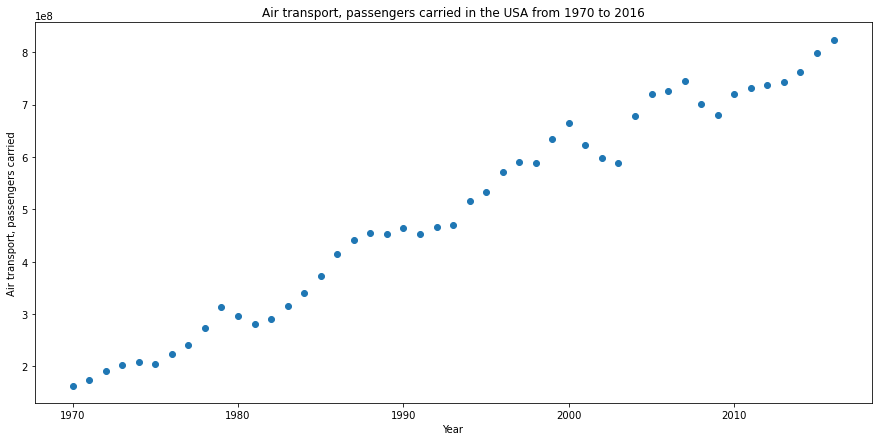

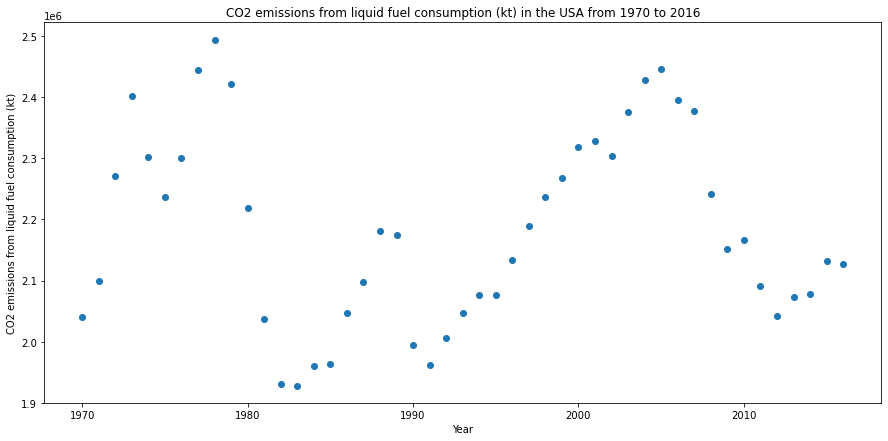

correlation coefficient is: 0.05727996729562196


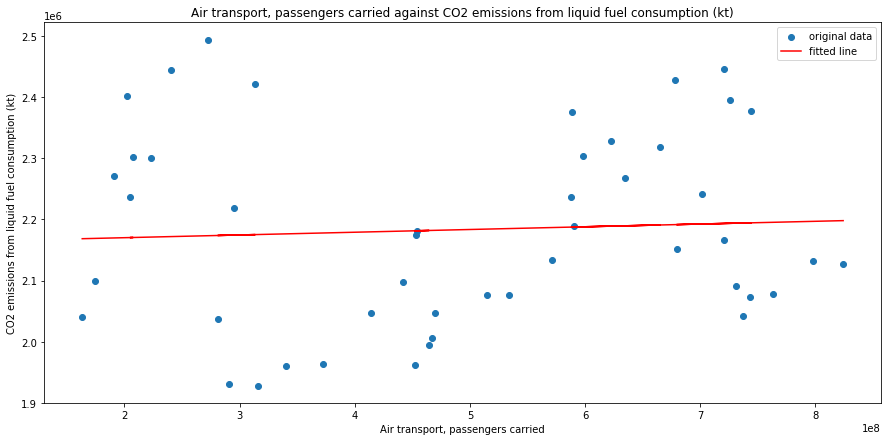

LinregressResult(slope=4.4767526782506634e-05, intercept=2161245.0513842343, rvalue=0.05727996729562196, pvalue=0.7021411998479979, stderr=0.00011631626643718978, intercept_stderr=61898.28686219432)



In [4]:

# read the air passengers file
dfAir = pd.read_excel('API_IS.AIR.PSGR_DS2_en_excel_v2_4676827.xls', header = 2)
# set the first row as the column names
dfAir = dfAir.rename(columns=dfAir.iloc[0]).loc[1:]
# get only the row of the US
dfAir = dfAir[dfAir['Country Code'] == 'USA'].dropna(axis= 1)
# get the Co2 emmissisons file
dfCo2 = pd.read_excel('API_EN.ATM.CO2E.LF.KT_DS2_en_excel_v2_4524769.xls', header = 2)
# set the first row as the column names
dfCo2 = dfCo2.rename(columns=dfCo2.iloc[0]).loc[1:]
# get only the row of the US
dfCo2 = dfCo2[dfCo2['Country Code'] == 'USA'].dropna(axis= 1)

# get the dates of 1970 to 2016
cols_selected = [1970.0, 1971.0,1972.0,1973.0,1974.0,1975.0,1976.0,1977.0,1978.0,1979.0,1980.0,1981.0,1982.0,1983.0,1984.0,1985.0,1986.0,1987.0,1988.0,1989.0,1990.0,1991.0,1992.0,1993.0,1994.0,1995.0,1996.0,1997.0,1998.0,1999.0,2000.0,2001.0,2002.0,2003.0,2004.0,2005.0,2006.0,2007.0,2008.0,2009.0,2010.0,2011.0,2012.0,2013.0,2014.0,2015.0,2016.0]

# transpose to get the dates as rows
dfCo2 = dfCo2[cols_selected].transpose()
# store the years in a column
dfCo2['Year'] = dfCo2.index
# rename the column
dfCo2.rename(columns = {252:'Co2 emission US'}, inplace = True)

# transpose to get the dates as rows
dfAir = dfAir[cols_selected].transpose()
# store the years in a column
dfAir['Year'] = dfAir.index
# rename the column
dfAir.rename(columns = {252:'Air passangers US'}, inplace = True)

# merge the two datasets based on year
dfMerged = dfAir.merge(dfCo2, on='Year', how = 'left')

# making the graph bigger for better visibility
plt.figure(figsize=(15, 7))
# plot number of air passengers against the year
plt.scatter(dfMerged['Year'] ,dfMerged['Air passangers US'])
# naming the x axis
plt.xlabel('Year')
# naming the y axis
plt.ylabel('Air transport, passengers carried')

# giving a title to my graph
plt.title('Air transport, passengers carried in the USA from 1970 to 2016')

plt.show()

# making the graph bigger for better visibility
plt.figure(figsize=(15, 7))
plt.scatter(dfMerged['Year'] ,dfMerged['Co2 emission US'])
# naming the x axis
plt.xlabel('Year')
# naming the y axis
plt.ylabel('CO2 emissions from liquid fuel consumption (kt)')

# giving a title to my graph
plt.title('CO2 emissions from liquid fuel consumption (kt) in the USA from 1970 to 2016')
plt.show()

correlation = dfMerged['Air passangers US'].corr(dfMerged['Co2 emission US'])

print('correlation coefficient is: ' + str(correlation))

# create a linear regression model
result = stats.linregress(dfMerged['Air passangers US'], dfMerged['Co2 emission US'])
# get the slope
slope = result.slope
# get the intercept
intercept = result.intercept
# the prediction function
y_hat = slope*dfMerged['Air passangers US'] + intercept

# making the graph bigger for better visibility
plt.figure(figsize=(15, 7))

# plot original data
plt.scatter(dfMerged['Air passangers US'],dfMerged['Co2 emission US'], label="original data")
# plot fitted line
plt.plot(dfMerged['Air passangers US'],y_hat,color="red", label="fitted line")

# naming the x axis
plt.xlabel('Air transport, passengers carried')
# naming the y axis
plt.ylabel('CO2 emissions from liquid fuel consumption (kt)')

# giving a title to my graph
plt.title('Air transport, passengers carried against CO2 emissions from liquid fuel consumption (kt)')

plt.legend()

plt.show()

print(result)

print()


# Question 4

LinregressResult(slope=0.13973362299465242, intercept=-270.18337210338683, rvalue=0.5407348863387454, pvalue=0.0011585109247269068, stderr=0.03904193819898755, intercept_stderr=77.92859536418155)


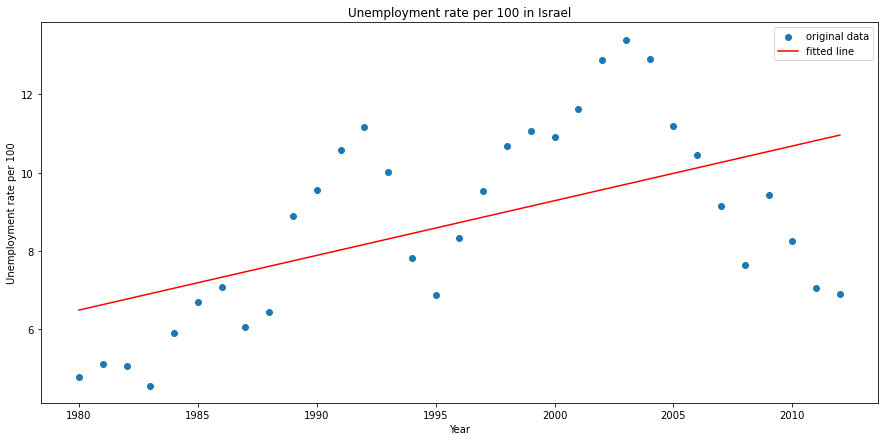

2020 prediction: 12.078546345811048
MAPE in %: 21.992601540272005


In [5]:
# Question 4

# setting my api key for quandl
quandl.ApiConfig.api_key = "BZzDay6TnuNnvx4x7Rzs"
# getting the respective wheat, oil and gold datasets
dfUnemployment = quandl.get('ODA/ISR_LUR')
# choosing the date range specified: 1980-12-31 to 2013-09-02
dfUnemployment = dfUnemployment.loc[dfUnemployment.index.to_series().between('1980-12-31', '2013-09-02')]
# adding a date column
dfUnemployment['Date'] = dfUnemployment.index

# building regression model
result = stats.linregress(dfUnemployment['Date'].dt.year, dfUnemployment['Value'])
print(result)
# get the slope
slope = result.slope
# get the intercept
intercept = result.intercept
# the prediction function
y_hat = slope*dfUnemployment['Date'].dt.year + intercept

# making the graph bigger for better visibility
plt.figure(figsize=(15, 7))

# plot original data
plt.scatter(dfUnemployment['Date'].dt.year, dfUnemployment['Value'], label="original data")
# plot fitted line
plt.plot(dfUnemployment['Date'].dt.year,y_hat,color="red", label="fitted line")

# naming the x axis
plt.xlabel('Year')
# naming the y axis
plt.ylabel('Unemployment rate per 100')

# giving a title to my graph
plt.title('Unemployment rate per 100 in Israel')

plt.legend()

plt.show()

# predict unemployment rate for 2020
predict_2020 = slope*2020 + intercept
print('2020 prediction: ' + str(predict_2020))

# a function that calculates the mean absolute percentage error
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

# calculating mape for unemployment data
print('MAPE in %: '+ str(mape(dfUnemployment['Value'], y_hat)))
